# Aquaseca basic domain
## Model Description before GroMore proposal 
This is a steady state box model with recharge and ET. An additional layer was also added to the model.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = varied 
- three layers

#### Topography
- Top layer elevation given in csv file
- Middle layer is flat and 5m thick
- Bottom layer (Layer 3) is flat and 40m thick

#### Subsurface Properties: 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001 
- Homogeneous in each layer
##### Layers
 - Layer 1 = Layer 3
     - Kx=Ky=Kz= 10m/d
 - Layer 2 
     - 20 leftmost columns, Kx=Ky=Kz= 10m/d
     - Other columns, Kz= 0.0001m/d

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to datum for all layers (datum is at bottom of domain)
 - All other boundaries are no flow
 - Top left corner: no flow
     - Extends from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells
 - A symmetric no flow region exists in the bottom left corner
     - row 41, column 1 to row 50, column 10.
 - Middle layer has no flow regions
     - Extends from row 43, column 1 to row 50, column 8 
 
#### ET: 
- Zero in left half
- 1E-5 m/day in the right half of the domain
- Riparian zone
    - Extends from left to right boundary of rows 23 to 29, inclusive
    - Rate: 5E-5m/d
- Extinction depth= 10m
 
#### Recharge: 
 - Leftmost 15 columns at a rate of 4E-5 m/d
 - Zero everywhere else

#### Stream:
- Begins in left boundary and goes to the right in row 26
- width=length=thickness= 1.0
- No flow is entering the stream
- streambed
    - K= 1000m/d
    - elevation= 1.0m below ground surface
    - stage= 0.5m
- "weak sink" with strength 0.5 (This is set under MODPATH/Particle Options.)
 
#### Well: 
 - Pumping well for Aquaseca
     - Completed in bottom layer
     - Located at row 21, column 38
     - Pumping at a rate of 1500 m^3/day 

## Model Description after GroMore proposal 

#### Ag field:
- cover a 2000m by 2000m area
- 1/8th of the area will be irrigated agriculture at any time (the field area is multiplied by 0.125). 
- Rectangular irrigated fields extend between rows 21 and 22 (inclusive) and columns 19 and 20 (inclusive).

##### ET
- ET for the crop is zero - it is accounted for in the calculated recharge 

##### Recharge
- Rate is 20% of the water demand of the crop, representing intentional excess irrigation to avoid soil salinization
- Crop water uses/recharge rates:
    - Wheat= 0.004m/d / 0.0001m/d
    - Pistachios= 0.006m/d / 0.00015m/d
    - Cotton: 0.008 m/d / 0.0002 m/d
    
##### Pumping Well:
- Completed in top layer
- Row 12 and column 14
- Pumping rate equal to the crop water demand plus 20% for excess irrigation plus 30% for irrigation inefficiency
    - Wheat= 3000 m3/day
    - Pistachos= 4500 m3/d
    - Cotton= 6000 m3/d
    
##### Monitoring wells
- Two monitoring in transient conditions
    - One at [25000, 25000] 
    - Other at [12500, 12500].

*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [3]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

flopy is installed in /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/flopy


## 2. Discretization and other inputs

In [8]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

#ztop = 100
ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)
#print(type(ztop))
#print(ztop.shape)
#print(ztop[0,:])
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction
#print(dz)

## Subsurface properties
#K_horiz = 1.    #horizontal hydraulic conductivity 
#K_vert = 1.    #assign vertical hydraulic conductivity (along z axis)
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## ET
ET_1 = 1e-5 #m/day
ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
rip_ET= 5e-5  #riparian zone
rip_locxy= [[0,21000],[23000,0]]
extinction_depth = 10 #m

# ET_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
# ET_cols=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx)) #convert the y locations to rows

# ET_rows2=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
# ET_cols2=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx))

ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (26.0, 49.0)

ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET_1
#print("ET location(col, row)", ET_cols,ET_rows)
#print("ETrows_forced:", ET_rows_forced)
#print("ETrows:", ET_rows)
#print("ETcols:", ET_cols)
#print("ETrows2:", ET_rows2)
#print("ETcols2:", ET_cols2)

rip_rows_forced = (21.0, 28.0)  #forced riparian area
rip_cols_forced = (1.0, 49.0)


# rip_rows=(np.floor(nrow-rip_locxy[1][1]/dy),np.floor(nrow-rip_locxy[0][1]/dy)) #convert the y locations to rows
# rip_cols=(np.floor(rip_locxy[0][0]/dx),np.floor(rip_locxy[1][0]/dx)) #convert the y locations to rows
rip_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 
#print("Riparian location(col, row)", rip_cols,rip_rows)

## Recharge
rech=4e-5  #m/d
rechxy=[(0,0),(0,36000)]  #recharge zone

rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 15 cols
rech_cols_forced = (1.0, 15.0)

rech_zone_forced = np.zeros((1, nrow,ncol))
rech_zone_forced[0, int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech


rech_rows=(np.floor(nrow-rechxy[1][1]/dy),np.floor(nrow-rechxy[0][1]/dy))
rech_cols=(np.floor(rechxy[0][0]/dx),np.floor(rechxy[1][0]/dx))
#rech_zone=np.zeros(1,nrow,ncol)
#rech_zone[0,int(rech_rows[0]):int(rech_rows[1]),int(rech_cols[0]):int(rech_cols[1])]=rech
print("recharge location(col, row)", rech_cols,rech_rows)

#supply well
pumping = 0 #m3/day 
well_xy= [38000, 29000] #xy location of well 
well_row = np.floor((nrow)-(well_xy[1]/dy)) #convert the y location to a row
well_col=np.floor(well_xy[0]/dx) #convert the x location to a column
well_row = 29
well_col = 37
well_loc = (0,well_row, well_col)
well = [2,well_row, well_col, pumping] #Well loc shoudl be layer, row, column
print("well1 location(layer, col, row)", well_row, well_col)


#MW1
pumping2 = 0 #m3/day 
well2_xy= [25000, 25000] #xy location of well 
well2_row = np.floor((nrow)-(well2_xy[1]/dy)) #convert the y location to a row
well2_col=np.floor(well2_xy[0]/dx)-1 #convert the x location to a column
well2_loc = (0,well2_row, well2_col)
well2 = [0,well2_row, well2_col, pumping2] #Well loc shoudl be layer, row, column
print("well2 location(layer, col, row)", well2_row, well2_col)

#MW2
pumping3 = 0 #m3/day 
well3_xy= [12500, 12500] #xy location of well 
well3_row = np.floor((nrow)-(well3_xy[1]/dy)) #convert the y location to a row
well3_col=np.floor(well3_xy[0]/dx) #convert the x location to a column
well3_loc = (0,well3_row, well3_col)
well3 = [0,well3_row, well3_col, pumping3] 
print("well3 location(layer, col, row)", well3_row, well3_col)


#irrigation well
pumping4 = 0 #m3/day 
well4_row = 38 
well4_col = 12 
well4_loc = (0,well4_row, well4_col)
well4 = [0,well4_row, well4_col, pumping4] 
print("well4 location(layer, col, row)", well4_row, well4_col)

wel_spd = {0: [well, well2, well3, well4]}

## Boundary conditions
h_right = 70


## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

recharge location(col, row) (0.0, 0.0) (14.0, 50.0)
well1 location(layer, col, row) 29 37
well2 location(layer, col, row) 25.0 24.0
well3 location(layer, col, row) 37.0 12.0
well4 location(layer, col, row) 38 12


## Seasons and Stessperiods

In [9]:
sp_peryr = 2   #number of seasons (with and wihtout ET. April-Sept and Oct-Mar)
sp1_len = 180  #sp lengths
sp2_len = 180
sim_years = 250
nper = int(sp_peryr*sim_years + 1)

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False     # steady-state or transient flag for each stress period (boolean array)
#print(steady)
steady[0] = True    # initial stress period is steady-state

#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)
perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation
print("Period lengths", perlen)

#make an nstp array for the # of time steps to solve within each period in this case we will do daily 
#so we can repeat the perlen array
nstp=perlen/20
nstp[0]=1 #for the steady state solution we just want one output
nstp = nstp.astype(int)
print("Number of Steps", nstp)



Period lengths [ 10 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180

## Set up varying ET

In [10]:

ET_0 = 0
ET_SS = (24/50)*ET_1+(6/50)*rip_ET  #SS ET guess will be about 1/2 ET rate because ET is happening on half domain (but doesnt include rip area)
print(ET_SS)

ET_val=np.tile([ET_1, ET_0],sim_years)
ET_val=np.append(ET_SS,ET_val)

ET = {}
ET_zone1 = ET_zone           # normal et periods
ET_zone2 = ET_zone*0        # 0 ET Periods
for p in range(0,nper):    #loop over stress periods
    #print(ET_val[p])
    if int(p%2) == 0:     #see if odd or evetn 
        ET[p]=ET_zone1
    else: 
        ET[p]=ET_zone2
    print(np.sum(ET[p]))
print(ET[9])


1.0800000000000002e-05
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.026230000000000003
0.0
0.

### Layering

In [11]:
## define layer properties 
K_horiz = 10 #m/d
K_vert = 10 #m/d
K_vert2 = 0.0001 #m/d  #K for the middle layer 


## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:49] = K_vert2            #Replace K in the middle layer with the lower value
#Kz[1,:,:] = K_vert2
#print(K_horiz)
#print(Kz)

## Make some changes to the parameters
bot_elev = 0.
mid_elev = 40.
top_elev = 45.

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 


## Boundary Conditions

In [12]:
#original BCS

#print(ibound)
#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value
#########################
#Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

## Stream

In [13]:
#DEFINE RIVERS
riv_row= 24
riv_sp = [] #create list to store all river cells for stress period 1
k_rivbott = 1000 #river bottom hydraulic conductivity in m/d
sed_thick = 1 #thickness of riverbed sediment in m
cond = k_rivbott*(1)*(1000)/(sed_thick) #river bed conductance in m^2/d
r_stage = .5 #stage in river (stress period 1)
r_bott = ztop[riv_row,:] #river bottom
#print(r_bott)
for i in range(1,ncol):
    riv_sp.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])
    
#print(riv_spd)
#create dictionary of stress period data
riv_spd = {0: riv_sp}
#print(riv_spd)

In [14]:
#create model object
modelname = "Scenario1"
#moddir="/Applications/MODFLOW/mf2005"
moddir = "/Users/abramfarley/Desktop/gw_modeling/ModFlow_Builds/pymake/examples/mf2005"
#moddir="C:/WRDAPP/MF2005.1_12/bin/mf2005.exe"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady, perlen=perlen, nstp=nstp)

# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)
#ET - evt
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53) 

#Recharge - rch
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone_forced, ipakcb=53)     #create rch object

#River - riv
riv = flopy.modflow.ModflowRiv(model=m, stress_period_data = riv_spd, ipakcb=53)

#Well - wel
#wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel1_spd)

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 

oc_spd = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        #print(kstp)
        oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']
#print(np.shape(oc_spd))
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=1500, iter1=500, relax = 0.97, damp = 0.5)

#write the inputs
m.write_input()   
m.evt.check()
m.oc.check()
m.oc.check()
m.lpf.check()
m.pcg.check()
m.riv.check()
m.rch.check()
m.dis.check()

#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

check method not implemented for EVT Package.

OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


LPF PACKAGE DATA VALIDATION:
  1 Warning:
    STORAGECOEFFICIENT option is activated, storage values are read storage coefficients

  Checks that passed:
    zero or negative horizontal hydraulic conductivity values
    zero or negative vertical hydraulic conductivity values
    negative horizontal anisotropy values
    horizontal hydraulic conductivity values below checker threshold of 1e-11
    horizontal hydraulic conductivity values above checker threshold of 100000.0
    vertical hydraulic conductivity values below checker threshold of 1e-11
    vertical hydraulic conductivity values above checker threshold of 100000.0
    zero or negative specific storage values
    specific storage values below checker threshold of 1e-06
    specific storage values above checker threshold of 0.01
    zero or negative 

 Solving:  Stress period:    10    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     1    Ground-Wa

 Solving:  Stress period:    22    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:     1    Ground-Wa

 Solving:  Stress period:    34    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     9    Ground-Wa

 Solving:  Stress period:    46    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     7    Ground-Wa

 Solving:  Stress period:    58    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:     5    Ground-Wa

 Solving:  Stress period:    70    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     5    Ground-Wa

 Solving:  Stress period:    82    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     5    Ground-Wa

 Solving:  Stress period:    94    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:     5    Ground-Wa

 Solving:  Stress period:   105    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     3    Ground-Wa

 Solving:  Stress period:   117    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     3    Ground-Wa

 Solving:  Stress period:   129    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:     3    Ground-Wa

 Solving:  Stress period:   141    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:     2    Ground-Wa

 Solving:  Stress period:   153    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     9    Ground-Wa

 Solving:  Stress period:   165    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     9    Ground-Wa

 Solving:  Stress period:   177    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     9    Ground-Wa

 Solving:  Stress period:   189    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     7    Ground-Wa

 Solving:  Stress period:   201    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:     5    Ground-Wa

 Solving:  Stress period:   212    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:     3    Ground-Wa

 Solving:  Stress period:   224    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:     1    Ground-Wa

 Solving:  Stress period:   236    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:     1    Ground-Wa

 Solving:  Stress period:   248    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:     9    Ground-Wa

 Solving:  Stress period:   260    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:     7    Ground-Wa

 Solving:  Stress period:   272    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:     6    Ground-Wa

 Solving:  Stress period:   284    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:     5    Ground-Wa

 Solving:  Stress period:   295    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:     3    Ground-Wa

 Solving:  Stress period:   307    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:     3    Ground-Wa

 Solving:  Stress period:   319    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:     3    Ground-Wa

 Solving:  Stress period:   331    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:     2    Ground-Wa

 Solving:  Stress period:   343    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:     9    Ground-Wa

 Solving:  Stress period:   355    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:     9    Ground-Wa

 Solving:  Stress period:   367    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:     8    Ground-Wa

 Solving:  Stress period:   379    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:     6    Ground-Wa

 Solving:  Stress period:   391    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:     4    Ground-Wa

 Solving:  Stress period:   403    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   403    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   403    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   403    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   403    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   403    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   403    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   403    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   403    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   404    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   404    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   404    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   404    Time step:     4    Ground-Wa

 Solving:  Stress period:   414    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   415    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   415    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   415    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   415    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   415    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   415    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   415    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   415    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   415    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   416    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   416    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   416    Time step:     3    Ground-Wa

 Solving:  Stress period:   426    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   426    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   427    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   427    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   427    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   427    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   427    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   427    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   427    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   427    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   427    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   428    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   428    Time step:     2    Ground-Wa

 Solving:  Stress period:   438    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   438    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   439    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   439    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   439    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   439    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   439    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   439    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   439    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   439    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   439    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   440    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   440    Time step:     2    Ground-Wa

 Solving:  Stress period:   450    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   450    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   450    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   451    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   451    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   451    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   451    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   451    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   451    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   451    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   451    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   451    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   452    Time step:     1    Ground-Wa

 Solving:  Stress period:   462    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   462    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   462    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   462    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   463    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   463    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   463    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   463    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   463    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   463    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   463    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   463    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   463    Time step:     9    Ground-Wa

 Solving:  Stress period:   474    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   474    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   474    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   474    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   474    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   475    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   475    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   475    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   475    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   475    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   475    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   475    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   475    Time step:     8    Ground-Wa

 Solving:  Stress period:   486    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   486    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   486    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   486    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   486    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   486    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   486    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   487    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   487    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   487    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   487    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   487    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   487    Time step:     6    Ground-Wa

 Solving:  Stress period:   498    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   498    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   498    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   498    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   498    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   498    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   498    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   498    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   499    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   499    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   499    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   499    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   499    Time step:     5    Ground-Wa

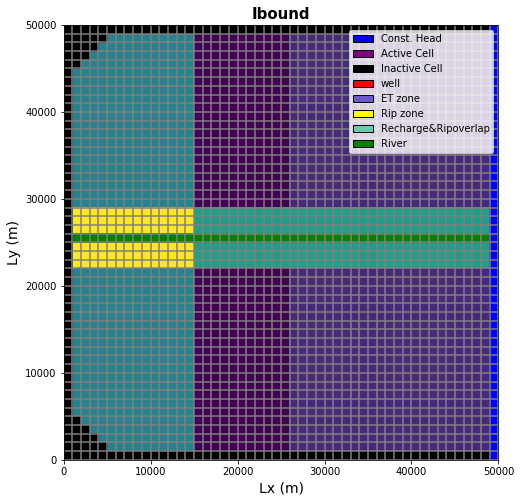

In [15]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.PlotMapView(model=m)
grid = modelmap.plot_grid()
zones = ET_zone + rech_zone_forced
quadmesh = modelmap.plot_array(zones)
riv_plot = modelmap.plot_bc(ftype='RIV')
quadmesh = modelmap.plot_ibound(ibound[0])
#quadmesh = modelmap.plot_bc('WEL')
#quadmesh = modelmap.plot_array(rech_zone_forced) #, color='purple')
#riv_plot = modelmap.plot_bc(ftype='RIV')
#chd_plot = modelmap.plot_bc(ftype='CHD')
#quadmesh = modelmap.plot_bc('WEL')
quadmesh = modelmap.plot_ibound()



#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='Purple',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                    mp.patches.Patch(color='red',label='well',ec='black'), 
                    mp.patches.Patch(color='slateblue',label='ET zone',ec='black'), 
                   mp.patches.Patch(color='yellow',label='Rip zone',ec='black'),
                    mp.patches.Patch(color='mediumaquamarine',label='Recharge&Ripoverlap',ec='black'),
                    mp.patches.Patch(color='green',label='River',ec='black')
                   ])

plt.show(modelmap)
#plt.savefig('Domaingrid.png')

In [16]:
hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
times = hds.get_times() # returns a list of timesteps
#times = []
# for t in range(len(perlen)):
#     if t == 0:
#         times.append(perlen[t])
#     else:
#         times.append(times[t-1]+perlen[t])
#print(times)

head = {} 
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')

for stress_per, time in enumerate(times): #iterate through times at end of each stress period
    head['sp%s'%(stress_per)] = headobj.get_data(totim=time) #append heads to head list for ea stress per
    #frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time) #append right face flow to frf list for ea stress per
    #fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per

In [37]:
len(times)


4501

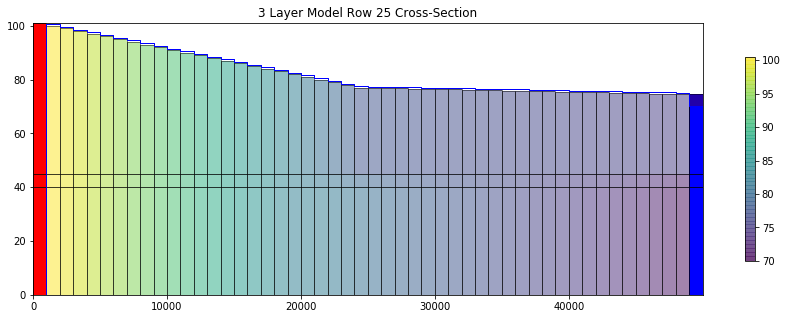

In [17]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='green')
# t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')

pc = xsect.plot_array(head['sp0'], masked_values=[-999.99], head=head, alpha=0.5)
patches = xsect.plot_ibound(head=head['sp0'])
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head['sp0'][0,:,:], masked_values=[999.], color='blue', lw=1)

## Plotting Heads

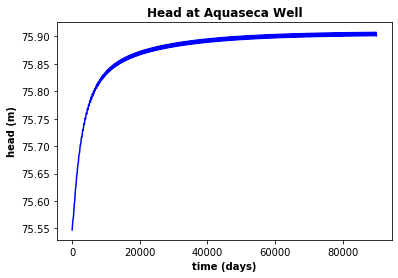

In [18]:

#plot a time series at cell left of river
#get time series for cell

cell_id1 = well_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at Aquaseca Well",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0], time_series1[:, 1], 'b-') #plot the time series with points at each record
#plt.show()
plt.savefig("Head_Aquaseca.png")

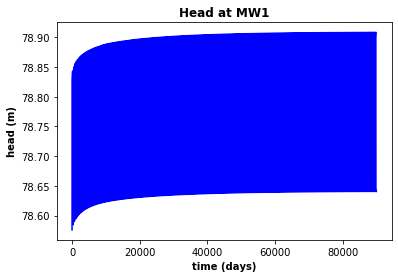

In [19]:

#plot a time series at cell left of river
#get time series for cell

cell_id1 = well2_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at MW1",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0], time_series1[:, 1], 'b-') #plot the time series with points at each record
#plt.show()
plt.savefig("MW1_head.png")

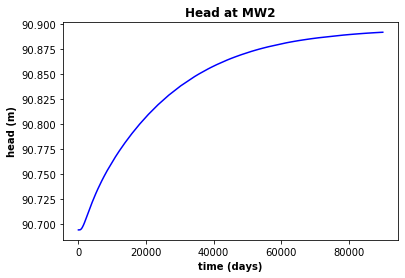

In [20]:

#plot a time series at cell left of river
#get time series for cell

cell_id1 = well3_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at MW2",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0], time_series1[:, 1], 'b-') #plot the time series with points at each record
#plt.show()
plt.savefig("MW2_head.png")

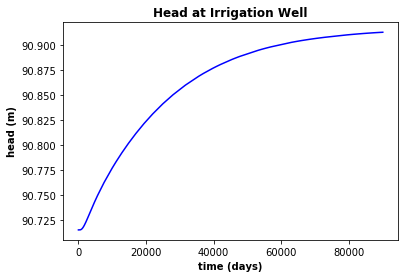

In [21]:

#plot a time series at cell left of river
#get time series for cell

cell_id1 = well4_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at Irrigation Well",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0], time_series1[:, 1], 'b-') #plot the time series with points at each record
#plt.show()
plt.savefig("Head_irrigation_well.png")

In [22]:
well_loc
head['sp0'][0][19][38]
#head['sp0'][well_loc[0]][well_loc[1]][well_loc[2]]



75.32979

In [23]:
type(times)
len(times)

4501

In [39]:
toplayer_h_init = head['sp4500'][0]
midlayer_h_init = head['sp4500'][1]
botlayer_h_init = head['sp4500'][2]

np.savetxt("toplayer_h_init.csv", toplayer_h_init, delimiter=",")
np.savetxt("midlayer_h_init.csv", midlayer_h_init , delimiter=",")
np.savetxt("botlayer_h_init.csv", botlayer_h_init , delimiter=",")


In [40]:
# toplayer_h_init = head['sp600'][0]
# midlayer_h_init = head['sp501'][1]
# botlayer_h_init = head['sp501'][2]

In [41]:
type(head)

dict

In [42]:
head.keys()

dict_keys(['sp0', 'sp1', 'sp2', 'sp3', 'sp4', 'sp5', 'sp6', 'sp7', 'sp8', 'sp9', 'sp10', 'sp11', 'sp12', 'sp13', 'sp14', 'sp15', 'sp16', 'sp17', 'sp18', 'sp19', 'sp20', 'sp21', 'sp22', 'sp23', 'sp24', 'sp25', 'sp26', 'sp27', 'sp28', 'sp29', 'sp30', 'sp31', 'sp32', 'sp33', 'sp34', 'sp35', 'sp36', 'sp37', 'sp38', 'sp39', 'sp40', 'sp41', 'sp42', 'sp43', 'sp44', 'sp45', 'sp46', 'sp47', 'sp48', 'sp49', 'sp50', 'sp51', 'sp52', 'sp53', 'sp54', 'sp55', 'sp56', 'sp57', 'sp58', 'sp59', 'sp60', 'sp61', 'sp62', 'sp63', 'sp64', 'sp65', 'sp66', 'sp67', 'sp68', 'sp69', 'sp70', 'sp71', 'sp72', 'sp73', 'sp74', 'sp75', 'sp76', 'sp77', 'sp78', 'sp79', 'sp80', 'sp81', 'sp82', 'sp83', 'sp84', 'sp85', 'sp86', 'sp87', 'sp88', 'sp89', 'sp90', 'sp91', 'sp92', 'sp93', 'sp94', 'sp95', 'sp96', 'sp97', 'sp98', 'sp99', 'sp100', 'sp101', 'sp102', 'sp103', 'sp104', 'sp105', 'sp106', 'sp107', 'sp108', 'sp109', 'sp110', 'sp111', 'sp112', 'sp113', 'sp114', 'sp115', 'sp116', 'sp117', 'sp118', 'sp119', 'sp120', 'sp121', '